<a href="https://colab.research.google.com/github/mimilazarova/DD2424-covid-xray-project/blob/master/covid_explainability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Questions
1. Does the LIME cells or change anything related to the data?    

  Grad_CAM does change the model but there is a cell that restore it. In the last cells grad-cam restore the model in the function before returning its value. 

2. There are 2 version of the LIME-plots. Which one should we use in the final plots?

3. Wht is the LIME-predictions compared to the regular model predictions?

4. Which SHAP outputs should we use? All 3 or just 1?

5. Which images should we train SHAP on?

In [1]:
pip install lime

In [2]:
pip install shap

In [3]:
# if scipy 1.2.0 is not already installed. 
!pip install scipy==1.2.0

In [0]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pickle
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import os


import sys

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
dirname = '/content/drive/My Drive/DD2424_Project/data/'
with open(os.path.join(dirname, 'trainX1.pickle'), 'rb') as f:
  trainX = pickle.load(f)

with open(os.path.join(dirname, 'testX.pickle'), 'rb') as f:
  testX = pickle.load(f)
with open(os.path.join(dirname, 'test_y.pickle'), 'rb') as f:
  test_y = pickle.load(f)


testN = testX.shape[0]
trainN = trainX.shape[0]

In [37]:
dirname = "/content/drive/My Drive/DD2424_Project/"
filename = "model8-undersampling-weights-augmentation.hdf5"
model = keras.models.load_model(os.path.join(dirname, filename))

test_y_pred_m = model.predict(testX)
test_y_pred = np.argmax(test_y_pred_m, axis=1)

def lime_predict(images, model=model):
  N = images.shape[0]
  images = images.reshape((N, 224, 224, 1))
  return model.predict(images)

test_y_pred_m_lime = lime_predict(testX)
test_y_pred_lime = np.argmax(test_y_pred_m_lime, axis=1)

conf_matrix = confusion_matrix(test_y, test_y_pred, labels=[0, 1, 2])
print("Test set")
print(conf_matrix)
print(classification_report(test_y, test_y_pred, digits=3))

Test set
[[98  2  0]
 [19 81  0]
 [ 7  9 15]]
              precision    recall  f1-score   support

           0      0.790     0.980     0.875       100
           1      0.880     0.810     0.844       100
           2      1.000     0.484     0.652        31

    accuracy                          0.840       231
   macro avg      0.890     0.758     0.790       231
weighted avg      0.857     0.840     0.832       231



In [38]:
# why isn't the conf_matrix above the same as here?
#   is the version of function lime_predict above used and necessary?
#   the results plots running this or the cell above are not the same
dirname = "/content/drive/My Drive/DD2424_Project/"
filename = "model8-undersampling-weights-augmentation-37-0.88.h5"
model = keras.models.load_model(os.path.join(dirname, filename))

preds_1hot = model.predict(testX)
preds = np.argmax(preds_1hot, axis=1)

conf_matrix = confusion_matrix(test_y, preds, labels=[0, 1, 2])
print("Test set")
print(conf_matrix)
print(classification_report(test_y, preds, digits=3))

Test set
[[95  5  0]
 [ 9 89  2]
 [ 2  2 27]]
              precision    recall  f1-score   support

           0      0.896     0.950     0.922       100
           1      0.927     0.890     0.908       100
           2      0.931     0.871     0.900        31

    accuracy                          0.913       231
   macro avg      0.918     0.904     0.910       231
weighted avg      0.914     0.913     0.913       231



---
## LIME


In [0]:
def lime_predict(images, model=model):
  N = images.shape[0]
  images = images.reshape((N, 224, 224, 3))
  images = images[:, :, :, 0] + images[:, :, :, 1] + images[:, :, :, 2]
  images = images /3.0
  return model.predict(images)


image:  0
explanation top label:  0
prediction:  0
true label:  0


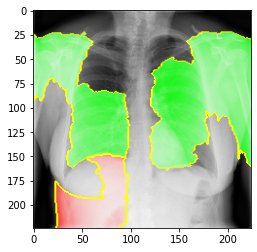

In [26]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

lime_explainer = lime_image.LimeImageExplainer()

for i in range(1):
  explanation = lime_explainer.explain_instance(image=testX[i], classifier_fn=lime_predict, top_labels=1, hide_color=0, num_samples=1000)
  print("image: ", i)
  print("explanation top label: ", explanation.top_labels[0])
  print("prediction: ", test_y_pred_lime[i])
  print("true label: ", test_y[i])
  temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
  plt.imshow(mark_boundaries(temp, mask))
  plt.show()

0


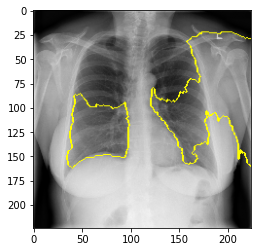

In [0]:
print(explanation.top_labels[0])
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))

---
---
Reshape test set for SHAP and Grad-CAM
---

In [0]:
testX = testX.reshape((testN, 224, 224, 1))
trainX = trainX.reshape((trainN, 224, 224, 1))

---
---
#Grad-CAM
---

In [0]:
import vis
from vis.utils import utils

import cv2 as cv2
from vis.visualization import visualize_cam

# change activation of last layer
layer_idx = len(model.layers)-1
model.layers[layer_idx].activation = keras.activations.linear


def plot_map(grad_top, image, alpha=0.5):
  # change image to match grad_top
  image = 255*image
  image = image.astype('uint8')
  image = np.repeat(image, 3, 2)

  # superimpose the gard_top over image and plot
  final = cv2.addWeighted(grad_top, 0.5, image, 0.5, 0)
  plt.imshow(final)
  plt.show()

def plot_grad_cam(x, y, pred, alpha=0.5):
  penultimate_layer_idx = len(model.layers) - 11 # last conv layer

  grad_top = visualize_cam(model, layer_idx, pred, x,
                         penultimate_layer_idx  = penultimate_layer_idx,
                         backprop_modifier      = None,
                         grad_modifier          = None)
  
  print("Ground Truth Label: ", y)
  print("Prediction Label: ", pred)
  plot_map(grad_top, x, alpha)
  return grad_top

In [0]:
healthy = np.argwhere(test_y == 0)[:, 0]
pneumonia = np.argwhere(test_y == 1)[:, 0]
covid19 = np.argwhere(test_y == 2)[:, 0]

pred_healthy = np.argwhere(test_y_pred == 0)[:, 0]
pred_pneumonia = np.argwhere(test_y_pred == 1)[:, 0]
pred_covid19 = np.argwhere(test_y_pred == 2)[:, 0]

correct_healthy = np.intersect1d(healthy, pred_healthy, True)
correct_pneumonia = np.intersect1d(pneumonia, pred_pneumonia, True)
correct_covid19 = np.intersect1d(covid19, pred_covid19, True)

false_healthy = pred_healthy[np.in1d(pred_healthy, correct_healthy, True, True)]
false_pneumonia = pred_pneumonia[np.in1d(pred_pneumonia, correct_pneumonia, True, True)]
false_covid19 = pred_covid19[np.in1d(pred_covid19, correct_covid19, True, True)]

Ground Truth Label:  0
Prediction Label:  0


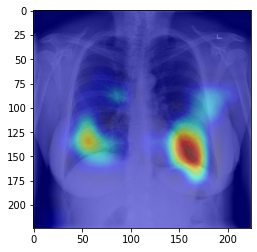

Ground Truth Label:  1
Prediction Label:  1


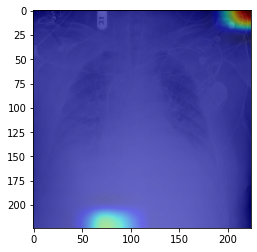

Ground Truth Label:  2
Prediction Label:  1


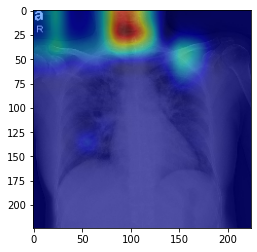

Ground Truth Label:  1
Prediction Label:  0


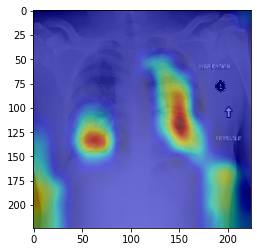

Ground Truth Label:  0
Prediction Label:  1


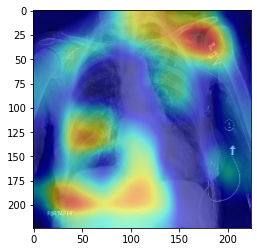

In [0]:
plot_grad_cam(testX[healthy[0]], test_y[healthy[0]], test_y_pred[healthy[0]])
plot_grad_cam(testX[pneumonia[0]], test_y[pneumonia[0]], test_y_pred[pneumonia[0]])
plot_grad_cam(testX[covid19[0]], test_y[covid19[0]], test_y_pred[covid19[0]])
plot_grad_cam(testX[false_healthy[0]], test_y[false_healthy[0]], test_y_pred[false_healthy[0]])
plot_grad_cam(testX[false_pneumonia[0]], test_y[false_pneumonia[0]], test_y_pred[false_pneumonia[0]])
plot_grad_cam(testX[false_covid19[0]], test_y[false_covid19[0]], test_y_pred[false_covid19[0]])

print()

In [0]:
# restore change made in model for Grad-CAM
model.layers[layer_idx].activation = keras.activations.softmax

---
---
SHAP
---

SHAP for the first 5 images

In [29]:
import shap
sys.setrecursionlimit(1000000)

shap.explainers.deep.deep_tf.op_handlers["AddV2"] = shap.explainers.deep.deep_tf.passthrough
shap.explainers.deep.deep_tf.op_handlers["FusedBatchNormV3"] = shap.explainers.deep.deep_tf.passthrough

# we use the first 50 training examples as our background dataset to integrate over
explainer = shap.DeepExplainer(model, trainX[:50, :, :, :])

# explain the first 5 predictions
# explaining each prediction requires 2 * background dataset size runs
shap_values = explainer.shap_values(testX[:5, :, :, :])

keras is no longer supported, please use tf.keras instead.


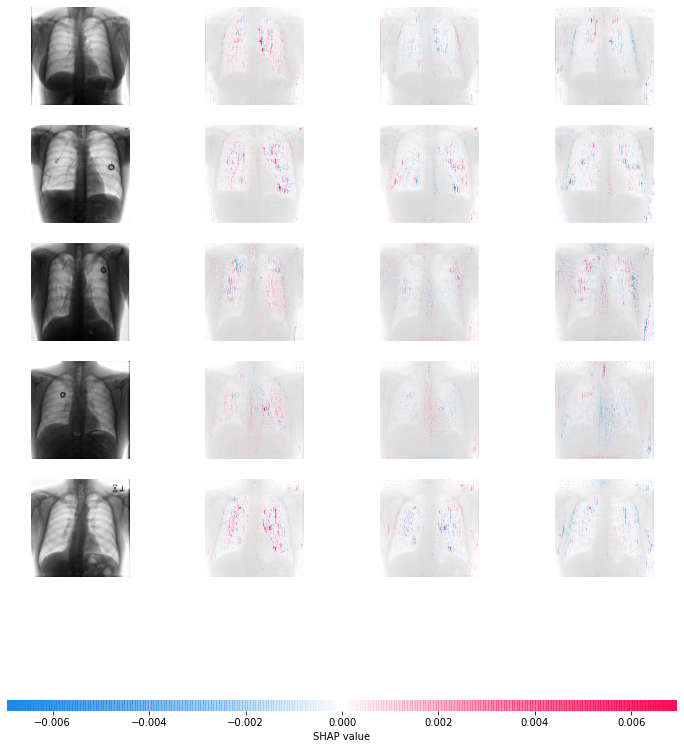

In [30]:
shap_numpy = [s for s in shap_values] 
test_numpy = testX[:5, :, :, :]
shap.image_plot(shap_numpy, -test_numpy)


# Plotting LIME, Grad-CAM and SHAP together
Idea is to have functions to generate plottable images for each explanation method and then call them all on a desired image and plot them side by side

In [41]:
img_idx = 0

print("true label: ", test_y[img_idx])
print("predicted label ", test_y_pred[img_idx])

true label:  0
predicted label  0



image:  0
explanation top label:  0
prediction:  0
true label:  0


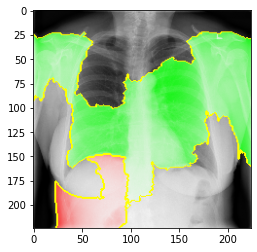

In [40]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

def lime_explain(testX, img_idx):

  # what is num_sample
  # what is num_features

  lime_explainer = lime_image.LimeImageExplainer()
  explanation = lime_explainer.explain_instance(image=testX[img_idx], classifier_fn=lime_predict, top_labels=1, hide_color=0, num_samples=1000)
  
  # what are these and should we keep printing then???
  print("explanation top label: ", explanation.top_labels[0])
  print("prediction: ", test_y_pred_lime[img_idx])

  # which one do we want to show?
  temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
  temp2, mask2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)

  return mark_boundaries(temp, mask), mark_boundaries(temp2, mask2)

In [0]:
import vis
from vis.utils import utils

import cv2 as cv2
from vis.visualization import visualize_cam

def gradCAM_explain(x, y, pred, alpha=0.5):
  # change activation of last layer
  layer_idx = len(model.layers)-1
  model.layers[layer_idx].activation = keras.activations.linear

  penultimate_layer_idx = len(model.layers) - 11 # last conv layer

  grad_top = visualize_cam(model, layer_idx, pred, x,
                         penultimate_layer_idx  = penultimate_layer_idx,
                         backprop_modifier      = None,
                         grad_modifier          = None)
  
  # change image to match grad_top
  image = 255*image
  image = image.astype('uint8')
  image = np.repeat(image, 3, 2)

  # superimpose the grad_top over image and plot
  final = cv2.addWeighted(grad_top, 0.5, image, 0.5, 0)

  # restore last layer to softmax
  model.layers[layer_idx].activation = keras.activations.softmax

  return final